In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from skimage import data, color, feature
import matplotlib.pyplot as plt
from skimage import transform

In [ ]:
def make_data_from_folder(path):
  data = []
  for img in os.listdir(path):
      pic = cv2.imread(os.path.join(path,img))
      pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
      # pic = cv2.resize(pic,(80,80))
      data.append(pic)
  return data

In [ ]:
def plot_images(images):
  fig, ax = plt.subplots(3, 5, figsize=(32, 16))
  for i, axi in enumerate(ax.flat):
      axi.imshow(images[i], cmap='gray')
      axi.axis('off')

In [ ]:
def apply_crop(images,x1,x2,y1,y2):
    #200:400,300:600
  return [img[x1:x2,y1:y2] for img in images]

In [ ]:
def apply_gray(images):
  return [color.rgb2gray(img) for img in images]

In [ ]:
correct_data = make_data_from_folder('/content/drive/MyDrive/new_felso_oldalso/correct')
incorrect_1_data = make_data_from_folder('/content/drive/MyDrive/new_felso_oldalso/incorrect_1')
incorrect_2_data = make_data_from_folder('/content/drive/MyDrive/new_felso_oldalso/incorrect_2')

pozitív tanító adatok:

In [ ]:
positive_patches = apply_gray(correct_data)
positive_patches = apply_crop(positive_patches, 280, 370, 280, 370)
positive_patches = np.stack(positive_patches, axis=0)
positive_patches.shape

(105, 90, 90)

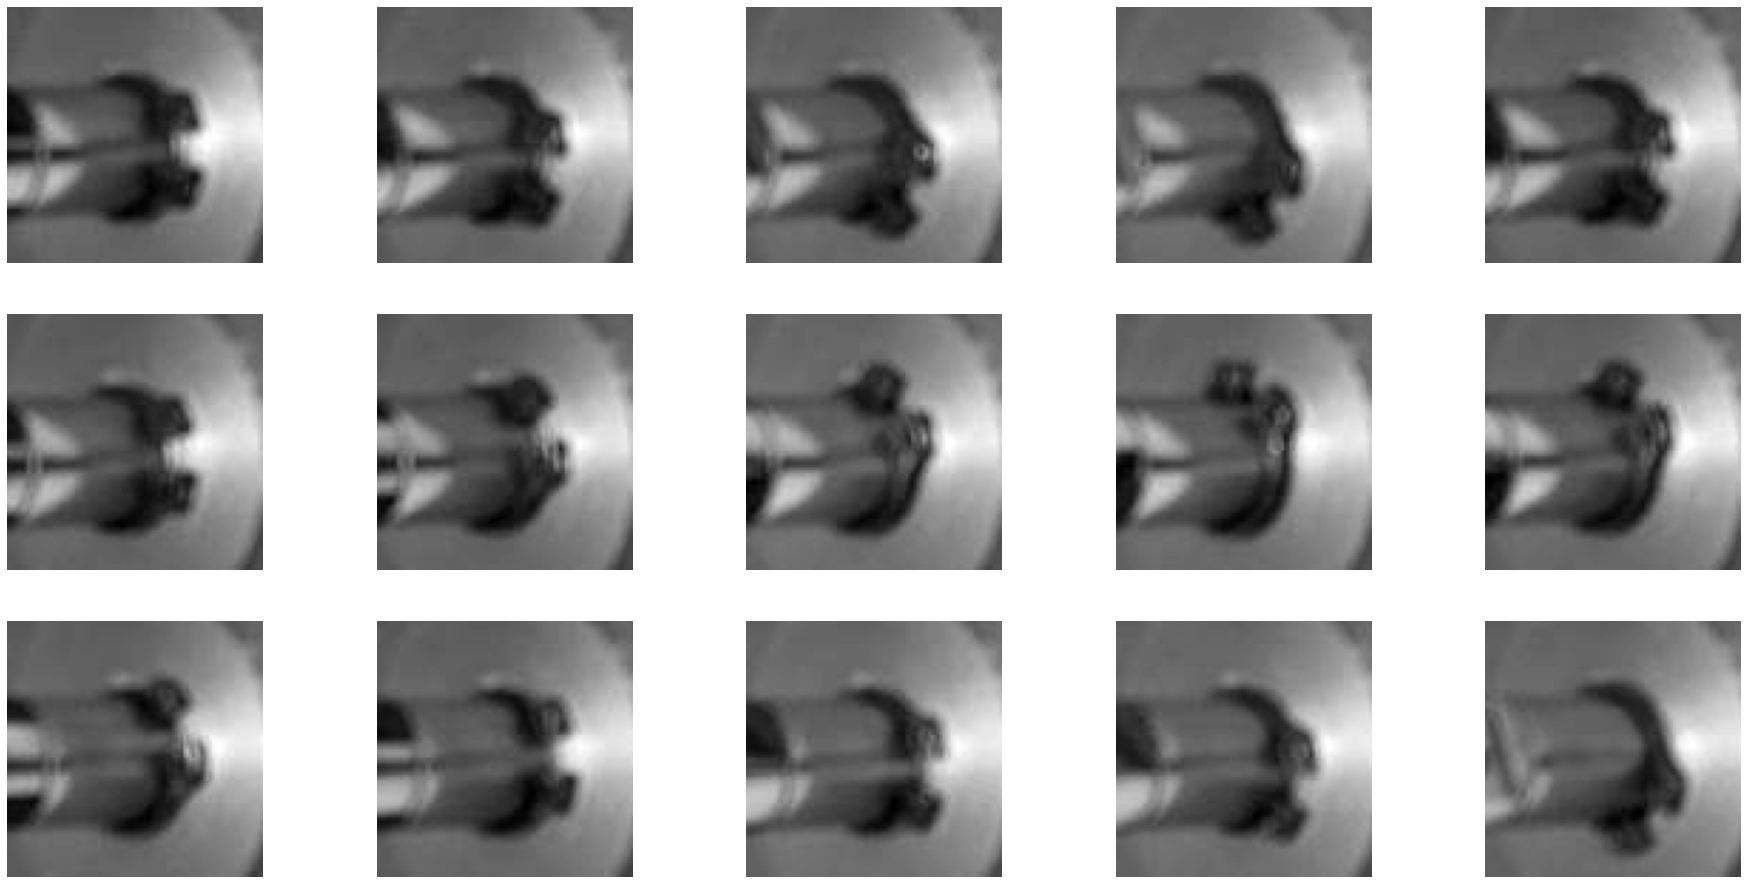

In [ ]:
plot_images(positive_patches)

Negatív tanító adatok (magasabb):

In [ ]:
negative_1_patches = apply_gray(incorrect_1_data)
negative_1_patches = apply_crop(negative_1_patches, 280, 370, 280, 370)
negative_1_patches = np.stack(negative_1_patches, axis=0)
negative_1_patches.shape

(104, 90, 90)

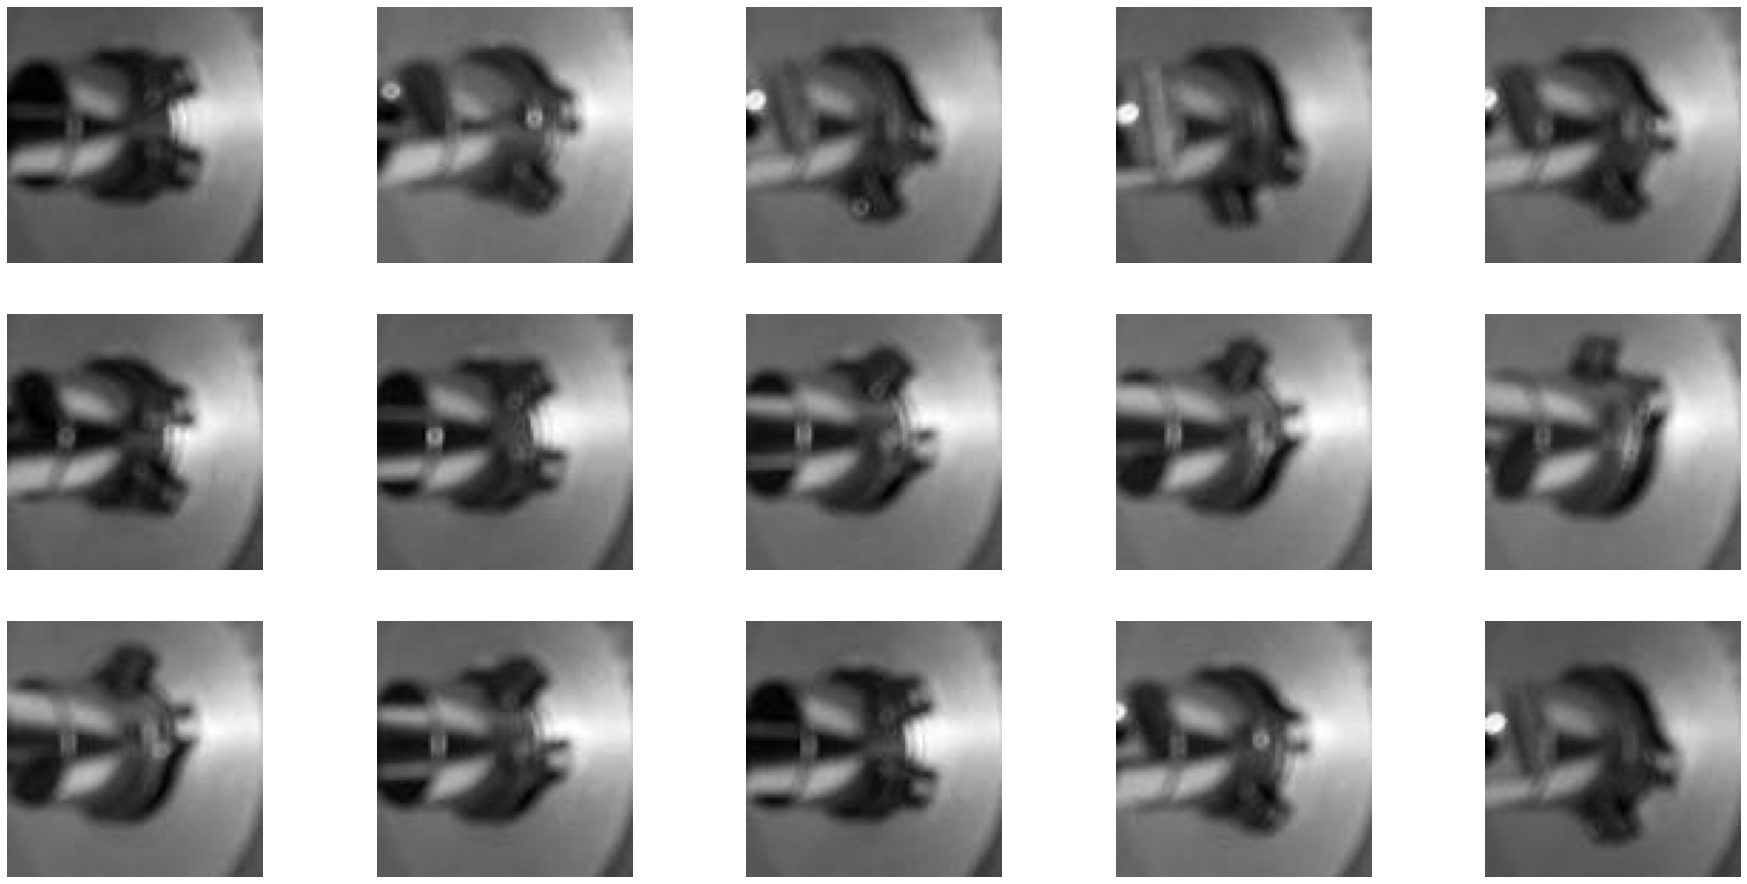

In [ ]:
plot_images(negative_1_patches)

Negatív tanító adatok (ferde):

In [ ]:
negative_2_patches = apply_gray(incorrect_2_data)
negative_2_patches = apply_crop(negative_2_patches, 280, 370, 280, 370)
negative_2_patches = np.stack(negative_2_patches, axis=0)
negative_2_patches.shape

(105, 90, 90)

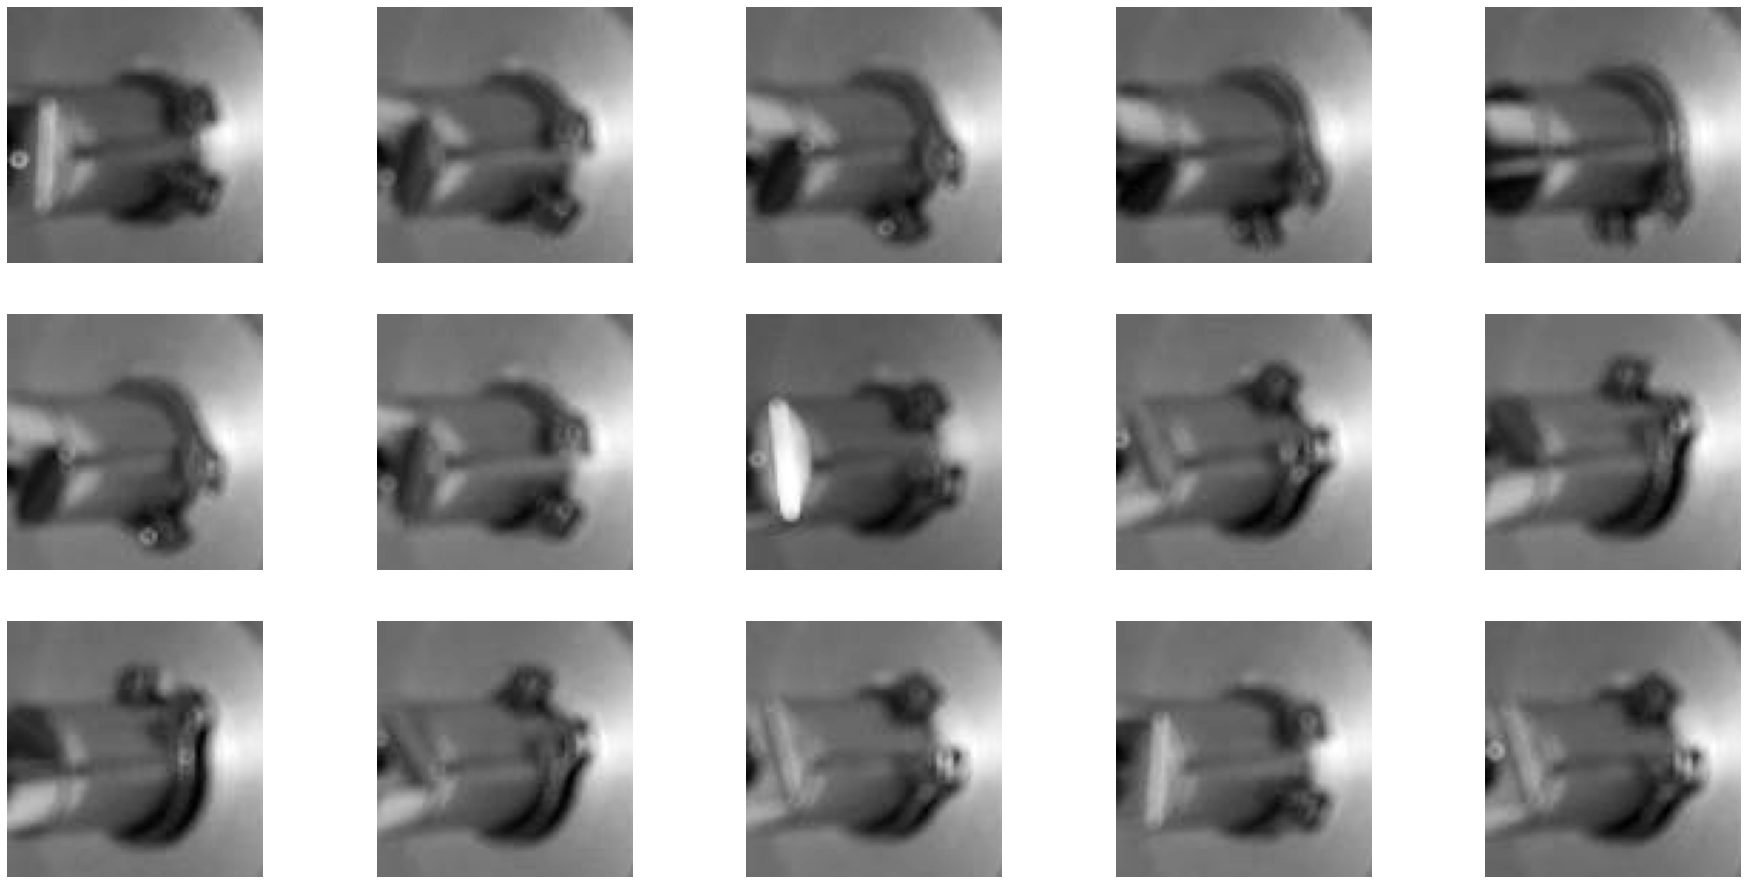

In [ ]:
plot_images(negative_2_patches)

In [ ]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_1_patches,
                                    negative_2_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
y_train[positive_patches.shape[0]:] = 2

In [ ]:
X_train.shape

(314, 6561)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [
    "Nearest Neighbors",
    #"Linear SVM",
    #"RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes"
    #"QDA",
]

classifiers = [
    KNeighborsClassifier(),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
    #QuadraticDiscriminantAnalysis(),
]

In [ ]:
from sklearn.model_selection import cross_val_score

for i, cf in enumerate(classifiers):
  print(f"{names[i]}: {cross_val_score(cf, X_train, y_train)}")

Nearest Neighbors: [0.46031746 0.68253968 0.34920635 0.66666667 0.64516129]
Decision Tree: [0.68253968 0.50793651 0.6031746  0.6031746  0.59677419]
Random Forest: [0.66666667 0.68253968 0.63492063 0.65079365 0.62903226]
Neural Net: [0.46031746 0.55555556 0.49206349 0.65079365 0.59677419]
AdaBoost: [0.58730159 0.53968254 0.44444444 0.58730159 0.48387097]
Naive Bayes: [0.36507937 0.55555556 0.38095238 0.57142857 0.48387097]


A KNN jó eredményeket produkált, ezért a továbbiakban ezt fogom használni, 
a következőkben a gyűrű detektálásával foglalkozom:

Új tanító adatok kellenek, ahol a jó = gyűrű van a képen, rossz = nem gyűrű van a képen

új negatív halmaz:

In [ ]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field', 
               'brick', 'retina', 'skin', 'rocket', 'logo']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


In [ ]:
# positive_1 = apply_gray(correct_data)
# positive_1 = apply_crop(positive_1, 230, 320, 230, 320)
# positive_1 = np.stack(positive_1, axis=0)

# positive_2 = apply_gray(incorrect_1_data)
# positive_2 = apply_crop(positive_1, 330, 420, 330, 420)
# positive_2 = np.stack(positive_1, axis=0)

# positive_3 = apply_gray(incorrect_2_data)
# positive_3 = apply_crop(positive_3, 280, 370, 470, 560)
# positive_3 = np.stack(positive_3, axis=0)

# negative_patches = np.array([img for img in chain(positive_1, positive_2, positive_3)])
# negative_patches.shape

all_images = []
images1 = apply_crop(images, 0, 90, 0, 90)
images2 = apply_crop(images, 82, 172, 90, 180)
images3 = apply_crop(images, 0, 90, 90, 180)
images4 = apply_crop(images, 82, 172, 0, 90)
images5 = apply_crop(images, 0, 90, 180, 270)
images6 = apply_crop(images, 82, 172, 180, 270)
images7 = apply_crop(images, 45, 135, 45, 135)
for i in range(15):
  all_images.append(images1[i])
  all_images.append(images2[i])
  all_images.append(images3[i])
  all_images.append(images4[i])
  all_images.append(images5[i])
  all_images.append(images6[i])
  all_images.append(images7[i])

# negative_patches = apply_gray(all_images)
negative_patches = np.stack(all_images, axis=0)
negative_patches.shape

(105, 90, 90)

In [ ]:
positive_patches.shape

(105, 90, 90)

In [ ]:
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [ ]:
X_train.shape

(210, 6561)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
# model.fit(X_train, y_train)

In [ ]:
test_image = color.rgb2gray(correct_data[0])
test_image = test_image[180:420,280:620]

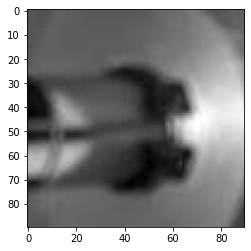

In [ ]:
plt.imshow(positive_patches[0], cmap='gray')

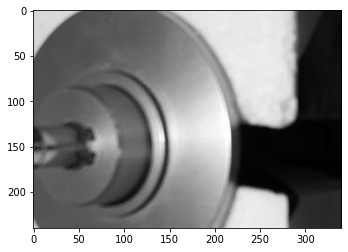

In [ ]:
plt.imshow(test_image, cmap='gray')

In [ ]:
test_image.shape

(240, 340)

In [ ]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches], dtype='object')
patches_hog.shape

KeyboardInterrupt: ignored

In [ ]:
# for i in range(30):
#   print(patches[i].shape)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.2, lw=2, facecolor='none'))

In [ ]:
results = []

for i, model in enumerate(classifiers):
  model.fit(X_train, y_train)
  
  indices, patches = zip(*sliding_window(test_image))
  patches_hog = np.array([feature.hog(patch) for patch in patches], dtype='object')

  matches = model.predict(patches_hog).sum()
  results.append(matches)
  print(f"{names[i]}: {matches}")
  